<table>
  <tr>
    <td><p style="font-size:45px; color: #55BBD2">Analysis of light microscopy images in Python</p></td>
    <td><img src="ressources/lmb_logo.svg" alt="LMB Logo" width="500" height="600" align="right"></td>
  </tr>
</table>
<table>
  <tr>
    <td><p style="font-size:15px; color: #55BBD2">Version: September 2025</p></td>
  </tr>
</table>

# Introduction to the course

The course aims to introduce you to the essential knowledge to image processing and analysis of microscopic data in Python. 

At the end of this course, we hope the course attendees will be able to:
- understand and establish an image analysis workflow
- run a Python notebook
- get familiar with relevant Python packages
- load and read microscopic image using the package AICSImageOI
- filter the noise of an image
- segment cells using watershed segmentation
- segment cells using cellpose
- extract relevant information from an image using the module regionprops and save the results in an excel sheet
- track a particle and trace the trajectories of the particles

To tackle each of those topics, we will have three analysis problem. 
To run the Python notebook, select Kernel and choose the environment 'imaging'.

We will also need to install a few packages if we are to run the notebook in Google colab. To do this, uncomment the code line in the next cell by removing the # at the beginning and run it.

### Downloading data is skipped at the momment

## Downloading data

Let us first download some data while looking at how to load a package. A package contains functions or modules that are ready to use.

In [ ]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from pathlib import Path

def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

url = 'https://cloud.mrc-lmb.cam.ac.uk/s/AegYyMp3ajfaZME/download/data.zip'
data_folder = Path('./data')
download_and_unzip(url, data_folder)

print(f'List of files in the {data_folder} folder')
for x in (data_folder).glob('*'):
    print(f' {str(x.name)}')
 

# Second analysis problem

## Colocalization problem

![title](ressources/data2.png)

In this second analysis problem, we will focus on a different problem. Our data consists of an image with four channels. <br>
- Channel 0: Golgi marker,
- Channel 1: cargo protein,
- Channel 2: mitochondria,
- Channel 3: the nuclei of the cell. 

With a particular treatement, the cargo moves to the mitochondria. Without the mentioned treatement, the cargo goes to the Golgi. Our problem then consists of quantifying the relocation of the cargo to the mitochondria and its relocation to the Golgi. We also want to understand how the high (transfected) or low presence (not transfected) of the mitochondria in the cell affect this relocation of the cargo. Hence, the workflow of our image analysis is illustrated as follows : <br>

<img src="ressources/workflow/workflow2.png" alt="drawing" width="800"/>

## Load data

In [1]:
from pathlib import Path
import tifffile

data_folder = Path("/Users/qwu/Documents/Python_projects/introduction-to-python-bioimage-analysis/") 
file_path = data_folder / "Zeiss1344.lsm"

# Open the image with tifffile
img = tifffile.imread(file_path)
print(img.shape)

# Read image data as a NumPy array
# col_data = img.data
# col_data_shape = col_data.shape


(4, 1220, 1220)


### Check if CUDA works

In [2]:
import torch

print(torch.__version__)        
print(torch.version.cuda)       
print(torch.cuda.is_available())

2.8.0
None
False


## Segment the cell using cellpose

Here we present a different technique for segmenting the cell. It uses a pretrained neural network for segmenting the image using two channels. <br> [Cellpose](https://cellpose.readthedocs.io/en/latest/) has been pretrained to detect cells or nuclei on a number of biological images.

In [ ]:
import matplotlib.pyplot as plt
from cellpose import models

# Get the pretrained model
model = models.Cellpose(gpu=False, model_type='cyto2')

# Evaluate the model
mask, flows, styles, diams = model.eval(img, channels=[2,3], diameter=400, cellprob_threshold=1.0)

# Display the results
fig, ax = plt.subplots(1,7, figsize=(15,5))
for k in range(4):
    ax[k].imshow(img[k], cmap='gray')
    ax[k].set_axis_off()
    ax[k].set_title('Ch'+str(k))
ax[4].imshow(mask)
ax[4].set_axis_off()
ax[4].set_title('Labels')
ax[5].imshow(flows[0])
ax[5].set_axis_off()
ax[5].set_title('Flows')
ax[6].imshow(flows[2])
ax[6].set_axis_off()
ax[6].set_title('Probability')
fig.tight_layout()

## Regions properties

In [5]:
from skimage import measure

props = measure.regionprops(mask)

## Using an interactive display
We will use the module 'interact' to view each labelled segmented region and observe if the segmentation was done as we expected it 

In [8]:
from ipywidgets import interact
import numpy as np

def displayf(label):
    p = props[label]
    single_mask = np.zeros(img.shape[-2:])
    single_mask[p.coords[:,0], p.coords[:,1]] = 1
    
    plt.imshow(img[2,:,:].squeeze(), cmap='hot')                          # mitochondria
    plt.imshow(img[3,:,:].squeeze(), alpha=0.5 , cmap='grey') # nuclei
    plt.imshow(single_mask, alpha=0.2)

    return 

interact(displayf, label=(0, len(props)-1, 1)) # min, max, step


interactive(children=(IntSlider(value=3, description='label', max=6), Output()), _dom_classes=('widget-interac…

<function __main__.displayf(label)>

<div class="alert alert-success">

#### Exercise       

The cell segmentation was obtained after setting the parameters: particle size to 400 pixels and cellprob_threshold = 1.0. <br>
Observe the segmented regions change if you change the particle size or the cellprob_threshold.    
</div>

## Measure the colocalization coefficient 

The Pearson's correlation coefficient (PCC) is widely used to quantify the colocalization of one object $A$ into another object $B$. It can be calculated using the following formula [1]:

$$\text{PCC} = \frac{\sum_i\left( A_i - A_{aver} \right) \cdot \left( B_i - B_{aver} \right)}{\sqrt{\left[ \sum_i \left( A_i - A_{aver} \right)^2 \cdot \sum_i \left( B_i - B_{aver} \right)^2 \right]}}$$

$A$: cargo protein in this problem with $A_i$ being the intensity at voxel $i$ and $A_{aver}$ the average value intensity \
$B$: organelles (mitochondria or Golgi) with $B_i$ being the intensity at voxel $i$ and $B_{aver}$ the average value intensity

PCC values range from -1 to 1. We will use the function pearsonr from the scipy.stats module to compute it. We will calculate the PCC between the organelles, mitochondria or Golgi, and the cargo protein to quantify how much cargo relocates to each corresponding organelle for a given treatement done on the cell. We will observe how different the PCC values are in high presence (transfected) and low presence (not transfected) of mitochondria in each cell respectively. <br>

We will apply the following notations:
- PCC1: PCC between the cargo protein and Golgi 
- PCC2: PCC between the cargo protein and mitochondria

Source [1]: Manders, E.M., Verbeek, F.J. and Aten, J.A., 1993. Measurement of co‐localization of objects in dual‐colour confocal images. Journal of microscopy, 169(3), pp.375-382.

In [9]:
import scipy.stats
from skimage import measure
import pandas as pd

ColCoeff = []
intensity_threshold = 1e6

for p in props:
    ch00 = img[0,:,:].squeeze()[p.coords[:,0], p.coords[:,1]] # Golgi marker
    ch01 = img[1,:,:].squeeze()[p.coords[:,0], p.coords[:,1]] # Cargo protein
    ch02 = img[2,:,:].squeeze()[p.coords[:,0], p.coords[:,1]] # Mitochondria
    sum_mitochondria = ch02.sum()
    if sum_mitochondria >= intensity_threshold:
        c = 'Transfected'
    else:
        c = 'Not transfected'

    
    [r1, pv] = scipy.stats.pearsonr(ch00, ch01)
    [r2, pv] = scipy.stats.pearsonr(ch01, ch02)
    ColCoeff.append({'label':p.label,'PCC1':r1, 'PCC2':r2, 'Area':p.area, 'Integrated intensity':sum_mitochondria, 'Condition':c})

ColCoeff = pd.DataFrame.from_records(ColCoeff)
ColCoeff

,label,PCC1,PCC2,Area,Integrated intensity,Condition
0,1,0.849356,0.389726,77252.0,348386,Not transfected
1,2,0.712557,0.653805,93218.0,1270294,Transfected
2,3,0.795263,0.344417,52436.0,248412,Not transfected
3,4,0.699593,0.684837,108762.0,1580431,Transfected
4,5,0.772451,0.475691,117916.0,538305,Not transfected
5,6,0.646173,0.462928,85777.0,401247,Not transfected
6,7,0.756169,0.314786,45859.0,226724,Not transfected


## Statistical analysis

We firstly analyse the data which corresponds to the relocation of the cargo to the Golgi. The relocation of the cargo to the mitochondria will be done as an exercise.

### p-value

The p-value is calculated from our statistical test. It describes how likely we are to have found the set of observations we have if there is no relationship between our conditions of interest (amount of mitochondria in each cell)

In [10]:
grp1 = ColCoeff[ColCoeff['Condition']=='Transfected']
grp2 = ColCoeff[ColCoeff['Condition']=='Not transfected']
pvalue = scipy.stats.mannwhitneyu(grp1['PCC1'],grp2['PCC1'])

print(pvalue)

MannwhitneyuResult(statistic=np.float64(2.0), pvalue=np.float64(0.38095238095238093))


## Display of the result
Display the PCC values, annotate the p-value and save the result into pdf file

/Users/qwu/micromamba/envs/cellpose_pytrain2/lib/python3.10/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Not transfected vs. Transfected: Custom statistical test, P_val:3.810e-01


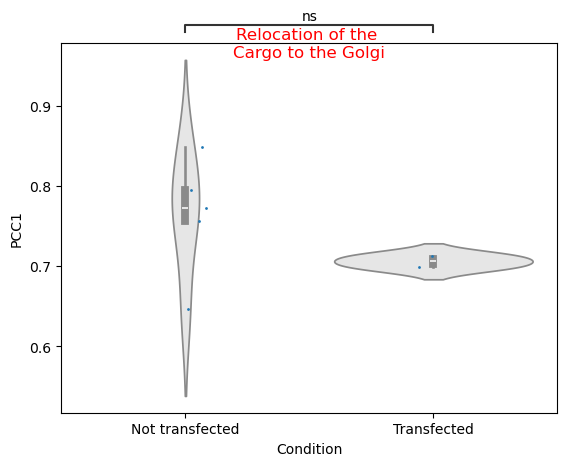

In [11]:
import seaborn as sns
from statannotations.Annotator import Annotator

conditions_list = ['Not transfected', 'Transfected']

plotting_parameters = {
    'data':    ColCoeff,
    'x':       'Condition',
    'y':       'PCC1',
    'order':   conditions_list,
}

ax = sns.violinplot(**plotting_parameters, color="0.9")
sns.stripplot(**plotting_parameters, jitter=True, size=2)

annotator = Annotator(ax, tuple([conditions_list]), **plotting_parameters)
annotator.set_pvalues([pvalue.pvalue])
annotator.configure(loc='outside')
annotator.annotate()

ax.set_title('Relocation of the \nCargo to the Golgi', y=1.0, pad=-10, c='red', horizontalalignment='center')

plt.savefig('PCC_Cargo_to_Golgi.pdf', format="pdf", bbox_inches="tight")


<div class="alert alert-success">

#### Exercise       

Display the result of the statistical analysis which corresponds to the relocation of cargo to the mitochondria. <br>
Make sure the title of the figure and the name under which the figure will be saved are updated.
   
</div>

<div class="alert alert-success">

#### Human in the loop       

python3 -m cellpose or cellpose  <br>
    
</div>